In [13]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from IPython.core.display import display, HTML

%pylab inline

plt.rcParams["font.family"] = 'serif'
plt.rcParams["font.size"] = '14'

display(HTML("<style>.container { width:98% !important; }</style>"))

Populating the interactive namespace from numpy and matplotlib


C:\Users\Francesca\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['average']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
series = pd.Series.from_csv('ibm_daily_1962-2018.csv', sep='\t',header=0)

# Preprocessing

In [3]:
#divisione della serie in anni
#OUTPUT: mod_series (record divisi in anni), years_list (lista di anni)
def SeriesToYears(series):
    years_groups = series.groupby(pd.Grouper(freq='A'));
    
    mod_series = []
    years_list = []
    for name, group in years_groups:
        year_values = pd.Series((group.values - group.values.mean())/group.values.std()).rolling(window=4, min_periods=1).mean()
        year_values = year_values.dropna()
        year_values = year_values.reset_index(drop=True)
        mod_series.append(year_values)
        years_list.append(name.year)
    
    #eliminazione ultimo anno (2018) perché incompleto
    years_list = years_list[0:(len(years_list)-1)]
    mod_series = mod_series[0:(len(mod_series)-1)]
    
    return mod_series, years_list

In [4]:
mod_series, years_list = SeriesToYears(series)

# DTW Sakoe-Chiba

In [5]:
def dtw_band(x, y, dist, band=inf):
    """
    Computes Dynamic Time Warping (DTW) of two sequences with Sakoe-Chiba band.

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int band: size of Sakow-Chiba band (default=inf)

    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    
    # D0 = D1 = matrix of point-to-point costs
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:] # view (hide first column and first row)
    
    # Fill the point-to-point costs matrix
    # Effect of bands: cells farther than "band" from diagonal have "inf" cost
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j]) if abs(i-j)<band else inf
            
    # C = matrix of optimal paths costs
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    
    # Infer the path from matrix C
    if len(x)==1:
        path = zeros(len(y)), range(len(y))  # special case 1
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))  # special case 2
    else:
        path = _traceback(D0)  # general case
        
    return D1[-1, -1], C, D1, path

# Function for inferring the optima path (general case)
# Starts from last cell and goes backward...
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)


def distance(x,y):
    return abs(x-y)

In [6]:
dd1 = [ [ ( dtw_band(mod_series[x],mod_series[y],distance, 30)[0] \
           if y > x else -1)  \
         for y in range(len(mod_series)) ] 
       for x in range(len(mod_series)) ]
# Copy values also to the lower half, exployting symmetry of the distance function
dd2 = [ [ (dd1[x][y] if y > x else dd1[y][x])  for y in range(len(mod_series)) ] for x in range(len(mod_series)) ]
# Finally, the diagonal
for i in range(len(mod_series)):
    dd2[i][i] = 0.0

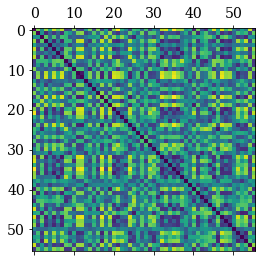

In [7]:
matshow(dd2, interpolation=None, aspect='auto')

# Calcolo Hierarchical Clustering

In [51]:
single_linkage = linkage(dd2, method='single')
complete_linkage = linkage(dd2, method='complete')
average = linkage(dd2, method='average')

C:\Users\Francesca\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.
C:\Users\Francesca\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  
C:\Users\Francesca\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
cmap = cm.gist_rainbow(np.linspace(0.1, 1, 7))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])
matplotlib.rcParams['lines.linewidth'] = 2

Visualizzazione Risultati:

In [53]:
def hier_lab(i): #funzione per la stampa dei nomi degli anni
    return years_list[i]

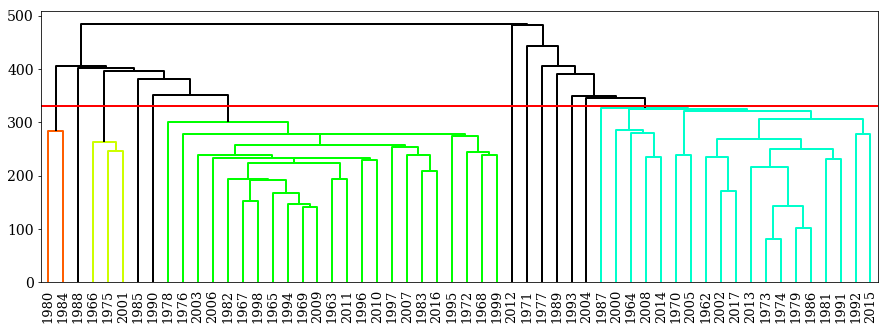

In [54]:
fig = plt.figure(figsize=(15, 5))
dn = dendrogram(single_linkage, color_threshold = 330, above_threshold_color  = '#000000', leaf_label_func = hier_lab)
plt.axhline(y=330, c='r')
xticks(fontsize=13)

plt.savefig('Images/TimeSeries/HierarcSakoeSingle.png', format='png', bbox_inches='tight')

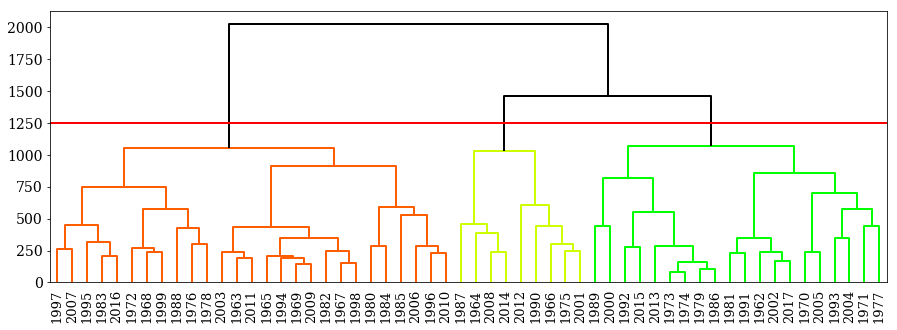

In [55]:
fig = plt.figure(figsize=(15, 5))
dn = dendrogram(complete_linkage, color_threshold = 1250, above_threshold_color  = '#000000', leaf_label_func = hier_lab)
plt.axhline(y=1250, c='r')
xticks(fontsize=13)

plt.savefig('Images/TimeSeries/HierarcSakoeComplete.png', format='png', bbox_inches='tight')

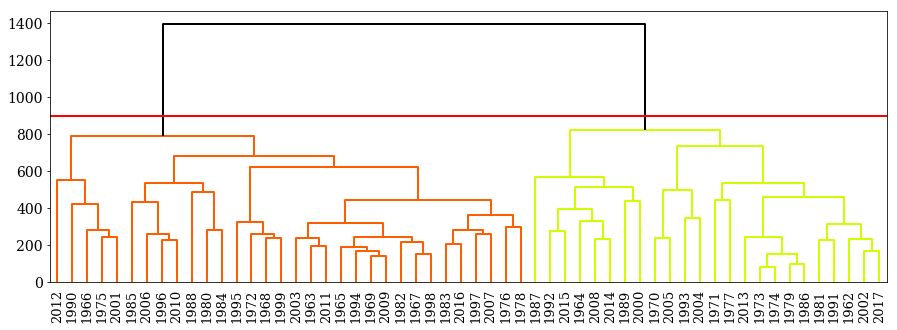

In [56]:
fig = plt.figure(figsize=(15, 5))
dn = dendrogram(average, color_threshold = 900, above_threshold_color  = '#000000', leaf_label_func = hier_lab)
plt.axhline(y=900, c='r')
xticks(fontsize=13)

plt.savefig('Images/TimeSeries/HierarcSakoeAVG.png', format='png', bbox_inches='tight')